In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
import matplotlib.pyplot as plt
from datetime import datetime
# Get the current time
current_time = datetime.now()
# Print the current time
print("Current time:", current_time)
!pip install dataretrieval
from dataretrieval import nwis
import random
from google.colab import drive
drive.mount('/content/drive')
!pip install hydroeval
import hydroeval as he
# Set seeds for all major libraries
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Current time: 2025-06-20 00:44:06.739147
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# --- 1. Generate Sample Data (Replace with your actual DataFrame) ---
# Assuming your DataFrame 'df' is already loaded.
# For demonstration, let's create a sample DataFrame:
#np.random.seed(42) # for reproducibility
#dates = pd.to_datetime(pd.date_range(start='2020-01-01', periods=200, freq='D'))
#x1 = np.sin(np.linspace(0, 50, 200)) + np.random.rand(200) * 0.5
#x2 = np.cos(np.linspace(0, 40, 200)) * 0.8 + np.random.rand(200) * 0.3
#y = 0.7 * x1 + 0.3 * x2 + np.sin(np.linspace(0, 60, 200)) * 0.5 + np.random.rand(200) * 0.2
#df = pd.DataFrame({'date': dates, 'x1': x1, 'x2': x2, 'y': y})

#print("Sample DataFrame Head:")
#print(df.head())
#print("\nDataFrame Info:")
#df.info()

In [29]:
startDate = "1995-10-01"
endDate = "2024-09-30"
model_site = [
'12322000'
 # "13296000" #"13311450"
               #'13190500' #'12305000' #'13340000' #'13317660'
#

 #'13192200'
 #'13211205'
 #'13311250'
         #     '13341050'
# '13150430'
          #    '13092747'
#  '13304050'
  #'13307000' #
  #
   #'13176400' #
# '13310800'
#  '12305000'


  #


  #'13340600' #
              #'13310850' #
   #'13311000'
              # '13342500'
            #  '13213000'# not enough data
#

   #
    #  #
   #
]
units_day = 365
missing_data_threshold = 0.90 *365

summer_months = [6,7,8]
summer_missing_data_threshold = 0.90 * (30+31+31)

site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
print("site_info_df:",site_info_df)
print("station_nm:",site_info_df['station_nm'][0])
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'station_nm','dec_lat_va', 'dec_long_va', 'drain_area_va', 'contrib_drain_area_va' ,   'alt_va'
                  # ,'alt_meth_cd', 'alt_acy_va', 'alt_datum_cd'
                  ]
filtered_df = site_info_df[columns_to_save]



parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate)
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )





dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year


dailyStreamtemp_df = dailyStreamtemp_df[ ~( (dailyStreamtemp_df["site_no"]=="13310800") & (dailyStreamtemp_df["Year"] == (2015) ) ) ]


shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)
prism_df['date'] = pd.to_datetime( prism_df['date'])

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365

prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
#prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)
# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)
#print( prism_df)
prism_df['Date'] = prism_df['date'].dt.date

prism_df = prism_df[['tmean' , "site_no", 'Date'
#, "rad_d"
 ]]

dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',  '00010_Mean', '00060_Mean'
   ]]

result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')

# Count the number of NaN values in each column
na_count = result.isna().sum()

# Drop rows with any NaN values
df_cleaned = result.dropna()

df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

train_month =  list(range( 3 , 8+1 ))


print("train_month:", train_month)

df_cleaned= df_cleaned[ df_cleaned['Date'].dt.month.isin( train_month )]

# Print the cleaned DataFrame
print("df_cleaned:",df_cleaned)

# Print the cleaned DataFrame
print(" df_cleaned.describe():",df_cleaned.describe())

# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()

print(na_count)

# gap

# Calculate time difference between consecutive dates
df_cleaned['Gap'] = df_cleaned['Date'].diff()

# Filter rows where the gap is more than expected (e.g., > 1 day)
expected_freq = pd.Timedelta(days=1)
gaps = df_cleaned[df_cleaned['Gap'] > expected_freq]

print("gaps",gaps)


site_info_df:   agency_cd   site_no                     station_nm site_tp_cd  lat_va  \
0      USGS  12322000  KOOTENAI RIVER AT PORTHILL ID         ST  485947   

   long_va  dec_lat_va  dec_long_va coord_meth_cd coord_acy_cd  ...  \
0  1163027   48.996389    -116.5075             G            S  ...   

  reliability_cd gw_file_cd  nat_aqfr_cd  aqfr_cd  aqfr_type_cd well_depth_va  \
0            NaN   NNNNNNNN          NaN      NaN           NaN           NaN   

  hole_depth_va depth_src_cd  project_no                    geometry  
0           NaN          NaN         NaN  POINT (-116.5075 48.99639)  

[1 rows x 43 columns]
station_nm: KOOTENAI RIVER AT PORTHILL ID
train_month: [3, 4, 5, 6, 7, 8]
df_cleaned:           tmean   site_no       Date  00010_Mean  00060_Mean
5585 -12.992001  12322000 2014-03-01         1.0      5730.0
5586 -10.980000  12322000 2014-03-02         0.5      5700.0
5587  -6.533000  12322000 2014-03-03         0.5      5730.0
5588  -0.083000  12322000 2014-03-

/tmp/ipython-input-29-3317525176.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
/tmp/ipython-input-29-3317525176.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Gap'] = df_cleaned['Date'].diff()


In [30]:
#features = ['x1', 'x2']
#target = 'y'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
#scaler_features = MinMaxScaler(feature_range=(0, 1))
#scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit and transform features
#df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
#df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

#print("\nDataFrame after Normalization Head:")
#print(df.head())

In [31]:
# --- 2. Preprocessing ---
# Select features and target
features = ['tmean',  '00060_Mean' ]
target = '00010_Mean'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
#  the minimum of feature is made equal to zero and the maximum of feature equal to one.
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

print(df_cleaned.shape)
df = df_cleaned
print(df.shape)
# Fit and transform features
df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

print("\nDataFrame after Normalization Head:")
#print(df.head())
print(df.tail())
#print(df.shape)

(1768, 6)
(1768, 6)

DataFrame after Normalization Head:
         tmean   site_no       Date  00010_Mean  00060_Mean    Gap
9417  0.596877  12322000 2024-08-27    0.773869    0.082523 1 days
9418  0.549459  12322000 2024-08-28    0.768844    0.080262 1 days
9419  0.646441  12322000 2024-08-29    0.758794    0.088628 1 days
9420  0.734653  12322000 2024-08-30    0.743719    0.087497 1 days
9421  0.769117  12322000 2024-08-31    0.733668    0.075740 1 days


/tmp/ipython-input-31-3284369372.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[features] = scaler_features.fit_transform(df[features])
/tmp/ipython-input-31-3284369372.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))


/tmp/ipython-input-32-46837385.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_12['Date'] = pd.to_datetime(df_12['Date'])


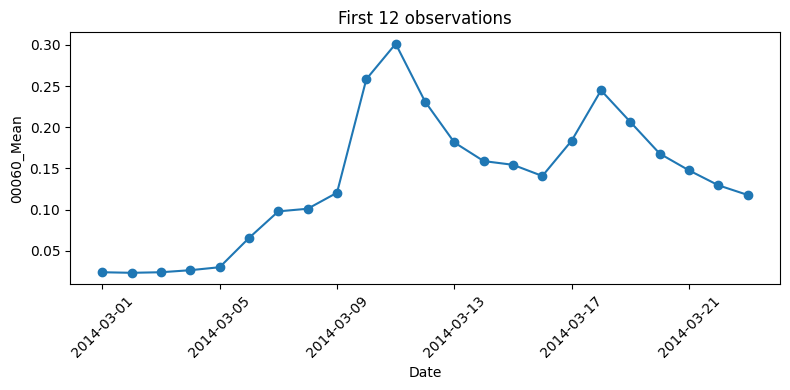

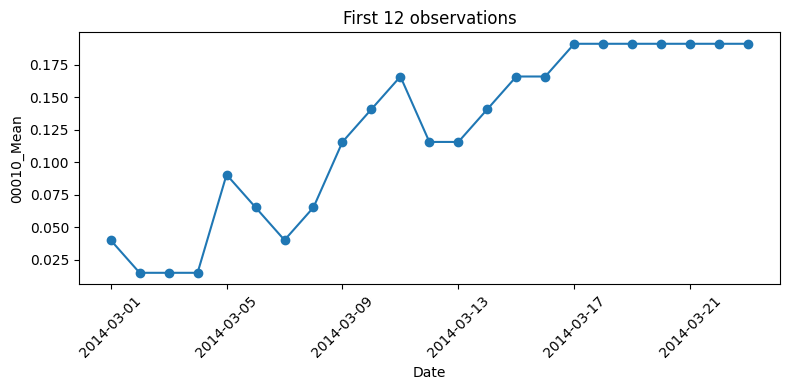

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your full DataFrame is called `df`
# 1) Keep only the first 12 rows
df_12 = df.head(23)        # or df.iloc[:12]

# 2) Make sure 'Date' is datetime (skip if it already is)
df_12['Date'] = pd.to_datetime(df_12['Date'])

# 3) Plot
plt.figure(figsize=(8, 4))          # optional size
plt.plot(df_12['Date'], df_12['00060_Mean'], marker='o')
plt.xlabel('Date')
plt.ylabel('00060_Mean')
plt.title('First 12 observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))          # optional size
plt.plot(df_12['Date'], df_12['00010_Mean'], marker='o')
plt.xlabel('Date')
plt.ylabel('00010_Mean')
plt.title('First 12 observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
# --- 3. Create Sequences for LSTM ---
# LSTMs require data in a 3D format: (samples, timesteps, features)
# 'timesteps' (also known as look_back) determines how many previous time steps
# the LSTM will consider to predict the next value.

look_back =  21 # You can adjust this based on your data's seasonality/dependencies

def create_sequences(data, look_back, features_cols, target_col):
    X, Y = [], []
    # Ensure data is a numpy array for efficient indexing
    data_np = data[features_cols + [target_col]].values # include target for sequence alignment
    #print(data.head)
    print("data_np:",data_np)
    # Features are the first 'num_features' columns, target is the last column.
    num_features = len(features_cols)

    for i in range(len(data_np) - look_back):
        # X: look_back historical features (x1, x2)
        X.append(data_np[i:(i + look_back +1), :num_features]) # (i + look_back +1) will include the feature of the day of the target
        # Y: the 'y' value at the current time step (i + look_back)
        Y.append(data_np[i + look_back, num_features]) # Target is the last column


    return np.array(X), np.array(Y)

X, Y = create_sequences(df, look_back, features, target)

print("X", X) # did I miss today's X?

# Print first 4 elements
print("First 4 Y elements:", Y[:4])

# Print last 4 elements
print("Last 4 Y elements:", Y[-4:])

print(f"\nShape of X (samples, timesteps, features): {X.shape}")
print(f"Shape of Y (samples, target_value): {Y.shape}")

data_np: [[0.         0.02396563 0.04020101]
 [0.04445093 0.02328736 0.01507538]
 [0.14269807 0.02396563 0.01507538]
 ...
 [0.64644058 0.08862763 0.75879397]
 [0.73465317 0.08749717 0.74371859]
 [0.76911699 0.07574045 0.73366834]]
X [[[0.         0.02396563]
  [0.04445093 0.02328736]
  [0.14269807 0.02396563]
  ...
  [0.3176518  0.16798553]
  [0.2945868  0.14763735]
  [0.29072054 0.12955008]]

 [[0.04445093 0.02328736]
  [0.14269807 0.02396563]
  [0.28519732 0.02645263]
  ...
  [0.2945868  0.14763735]
  [0.29072054 0.12955008]
  [0.33959005 0.11779335]]

 [[0.14269807 0.02396563]
  [0.28519732 0.02645263]
  [0.36890734 0.03007009]
  ...
  [0.29072054 0.12955008]
  [0.33959005 0.11779335]
  [0.34029702 0.12728917]]

 ...

 [[0.80452528 0.12502826]
  [0.7927564  0.09654081]
  [0.7590614  0.09134072]
  ...
  [0.59687737 0.08252317]
  [0.54945938 0.08026227]
  [0.64644058 0.08862763]]

 [[0.7927564  0.09654081]
  [0.7590614  0.09134072]
  [0.77124121 0.09269726]
  ...
  [0.54945938 0.08026

In [34]:
# --- 4. Train-Test Split (Time Series Split) ---
# It's crucial to split time series data chronologically to avoid data leakage.
train_size = int(len(X) * 0.8) # e.g., 80% for training, 20% for testing
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(f"Train samples: {len(X_train)}")


print(f"Test samples: {len(X_test)}")
print(f" Y Train samples: {len(Y_train)}")


print(f"Y Test samples: {len(Y_test)}")

Train samples: 1397
Test samples: 350
 Y Train samples: 1397
Y Test samples: 350


In [35]:
print("X_train[0]:", X_train[0])
print("Y_train[0]:", Y_train[0])


print("df.head(6)",df.head(6))
#print("X:", X)
#print("Y:", Y)


#print("X_train:", X_train)
#print("Y_train:", Y_train)
print("Y_train.shape:", Y_train.shape)
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)

X_train[0]: [[0.         0.02396563]
 [0.04445093 0.02328736]
 [0.14269807 0.02396563]
 [0.28519732 0.02645263]
 [0.36890734 0.03007009]
 [0.41863847 0.06556636]
 [0.38174332 0.09789735]
 [0.3743201  0.10106263]
 [0.3945572  0.12050644]
 [0.35845739 0.25842189]
 [0.34297026 0.30137915]
 [0.37135965 0.23129098]
 [0.37018873 0.18155098]
 [0.33556914 0.15894189]
 [0.3459749  0.15442008]
 [0.37659567 0.14085462]
 [0.33775634 0.18381189]
 [0.34376561 0.24485643]
 [0.34084935 0.20642098]
 [0.3176518  0.16798553]
 [0.2945868  0.14763735]
 [0.29072054 0.12955008]]
Y_train[0]: 0.19095477386934673
df.head(6)          tmean   site_no       Date  00010_Mean  00060_Mean    Gap
5585  0.000000  12322000 2014-03-01    0.040201    0.023966    NaT
5586  0.044451  12322000 2014-03-02    0.015075    0.023287 1 days
5587  0.142698  12322000 2014-03-03    0.015075    0.023966 1 days
5588  0.285197  12322000 2014-03-04    0.015075    0.026453 1 days
5589  0.368907  12322000 2014-03-05    0.090452    0.030070

/tmp/ipython-input-36-2831626437.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot([array1, array2],


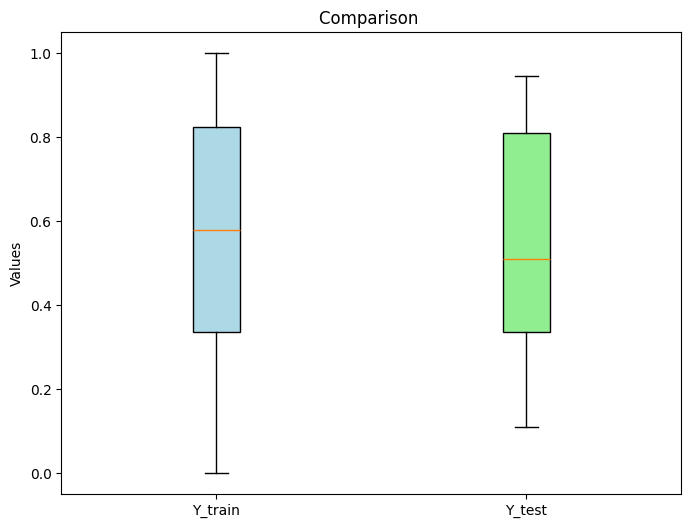

Number of zeros Y_train: 2


In [36]:


import matplotlib.pyplot as plt
import numpy as np  # Only needed if you're creating example data

# Example data (replace with your actual arrays)
array1 = Y_train
array2 =  Y_test

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Create the boxplot
boxplot = plt.boxplot([array1, array2],
                     patch_artist=True,
                     labels=['Y_train', 'Y_test'])

# Customize colors (optional)
colors = ['lightblue', 'lightgreen']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Add title and labels
plt.title('Comparison ')
plt.ylabel('Values')

# Show the plot
plt.show()

num_zeros = Y_train.size - np.count_nonzero(Y_train)

print(f"Number of zeros Y_train: {num_zeros}")

In [37]:
model_params = {
    'h1': 256,
    'h2': 100,
   # 'learning_rate': 0.0001,
   # 'dropout_rate_1': 0.2,
   # 'dropout_rate_2': 0.1,
   # 'loss_function': 'mean_squared_error',


}

h1 = model_params['h1']
h2 = model_params['h2']
#learning_rate = model_params['learning_rate']
#d1 = model_params['dropout_rate_1']
#d2 = model_params['dropout_rate_2']



In [38]:
# --- 5. Build LSTM Model ---
#h1=  128
#h2 =  128
learning_rate = 0.0001
optimizer= Adam(learning_rate= learning_rate ) #'adam'
#Adadelta(learning_rate=learning_rate)
d1 = 0.1
d2 = 0.1

model = Sequential()
# First LSTM layer with return_sequences=True to pass sequences to the next LSTM layer
model.add(LSTM(units= h1, return_sequences=True, input_shape=(look_back, len(features))))
model.add(Dropout( d1 )) # Dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(units= h2, return_sequences=False)) # return_sequences=False for the last LSTM layer
model.add(Dropout( d2 ))

# Dense output layer for regression (predicting a single value 'y')
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.__class__.__name__}, Activation: {getattr(layer, 'activation', 'N/A')}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 21, 256)        │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │       142,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 408,117 (1.56 MB)

 Trainable params: 408,117 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

Layer 0: LSTM, Activation: <function tanh at 0x7e07cb77e3e0>
Layer 1: Dropout, Activation: N/A
Layer 2: LSTM, Activation: <function tanh at 0x7e07cb77e3e0>
Layer 3: Dropout, Activation: N/A
Layer 4: Dense, Activation: <function linear at 0x7e07cb77ea20>


Epoch 1/105
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1391 - val_loss: 0.0301
Epoch 2/105
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0242 - val_loss: 0.0297
Epoch 3/105
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0212 - val_loss: 0.0253
Epoch 4/105
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0181 - val_loss: 0.0221
Epoch 5/105
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0158 - val_loss: 0.0202
Epoch 6/105
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0148 - val_loss: 0.0214
Epoch 7/105
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0131 - val_loss: 0.0198
Epoch 8/105
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0127 - val_loss: 0.0237
Epoch 9/105
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0126 - val_loss: 0.0211
Epoch 10/105
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0119 - val_loss: 0.0225
Epoch 11/105
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0120 - val_loss: 0.0199
Epoch 12/105
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.

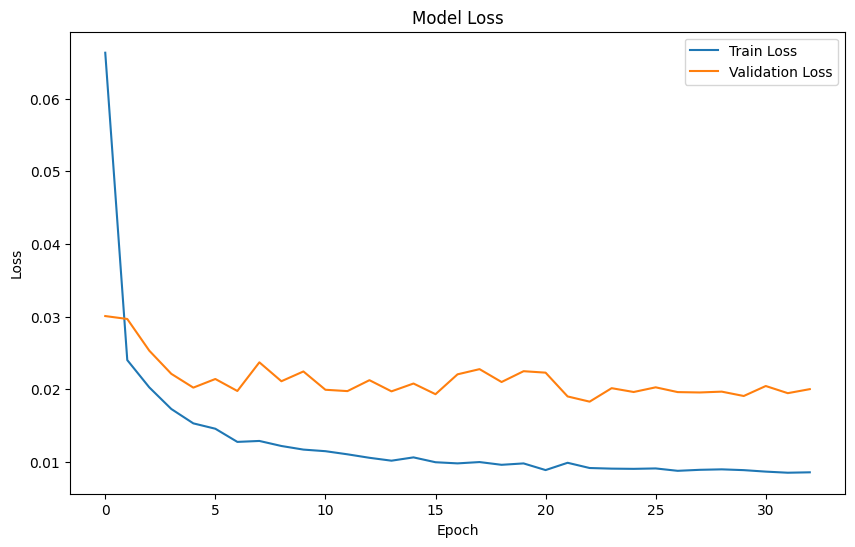

In [39]:
# --- 6. Train the Model ---
# EarlyStopping to stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
batch =  16
history = model.fit(X_train, Y_train,
                    epochs=105, # You can increase epochs, EarlyStopping will handle it
                    batch_size= batch ,
                    validation_split=0.2, # Use a portion of training data for validation
                    callbacks=[early_stopping],
                    verbose=1)

#print(history)
# Print the epoch the model stopped at
print(f"Training stopped at epoch: {len(history.history['loss'])}")

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [40]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 21, 256)        │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │       142,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,224,353 (4.67 MB)

 Trainable params: 408,117 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 816,236 (3.11 MB)

In [41]:
# --- 7. Evaluate the Model ---
train_loss = model.evaluate(X_train, Y_train, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f"\nTrain Loss (MSE): {train_loss:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}")


Train Loss (MSE): 0.0104
Test Loss (MSE): 0.0091


In [42]:
# --- 8. Make Predictions ---
# Make predictions on the test set
Y_pred_scaled = model.predict(X_test)
print(f"\nShape of Y_pred_scaled: {Y_pred_scaled.shape}")
print(f"Shape of Y_test: {Y_test.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Inverse transform the predictions and actual values to the original scale
Y_pred = scaler_target.inverse_transform(Y_pred_scaled)
Y_test_original = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

r2 = r2_score( Y_test_original ,  Y_pred )

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test_original, Y_pred))
print(f"Test RMSE: {rmse:.4f}")

bias =np.mean( Y_pred- Y_test_original)
print(f"Test bias: { bias:.4f}")

# KGE calculation using hydroeval
# Note: hydroeval's kge function returns KGE, r, alpha, beta by default
kge_value, r_comp, alpha_comp, beta_comp = he.kge( Y_pred , Y_test_original)
#print( kge_value)

std_ratio = np.std( Y_pred ) / np.std( Y_test_original ) # standard deviation ratio
correlation = np.corrcoef( Y_pred.flatten() ,  Y_test_original.flatten() )[0, 1]
print("correlation", correlation)

print(np.std(Y_pred))
print(np.std(Y_test_original))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Shape of Y_pred_scaled: (350, 1)
Shape of Y_test: (350,)
Shape of X_test: (350, 22, 2)
Test RMSE: 1.8977
Test bias: 1.0837
correlation 0.9513650188881047
5.009602
4.978136820546582


In [43]:



# Example arrays
x = np.array([1, 2, 3, 4, 5])
print(x.shape)
y = np.array([2, 4, 6, 8, 10])

# Compute the correlation coefficient matrix
correlation_matrix = np.corrcoef(x, y)

# Extract the correlation coefficient (Pearson's r)
correlation_example = correlation_matrix[0, 1]

print("Correlation coefficient:", correlation_example)


print("Y_test_original",Y_test_original.shape)
print("Y_test_original",type(Y_test_original) )
print(np.isnan(Y_test_original).sum())
print(np.isinf(Y_test_original).sum())
print("Y_pred",Y_pred.shape)
print("Y_pred",type(Y_pred))
print(np.isnan(Y_pred).sum())
print(np.isinf(Y_pred).sum())

(5,)
Correlation coefficient: 0.9999999999999999
Y_test_original (350, 1)
Y_test_original <class 'numpy.ndarray'>
0
0
Y_pred (350, 1)
Y_pred <class 'numpy.ndarray'>
0
0


In [44]:
#Y_pred
#Y_test_original
#print(Y_pred .shape)
#df_cleaned[train_size:len(Y)]['Date']


#dt_ys = df_cleaned[train_size:len(Y)]#['Date']

print("df_cleaned.tail:",df_cleaned.tail)
print((len(Y)-Y_test.shape[0]  ))
print(len(Y) )
dt_ys = df_cleaned.iloc[  ( df_cleaned.shape[0]-Y_test.shape[0]  )  : df_cleaned.shape[0] ]#['Date']

dt_ys['Y_pred'] = Y_pred
dt_ys['Y_test_original']= Y_test_original

dt_ys[['Date','Y_pred', 	'Y_test_original']]

dt_ys['Date'] = pd.to_datetime( dt_ys['Date'])

print( "dt_ys.tail()", dt_ys.tail() )

print( dt_ys['Date'].dt.month.describe())

summer_df = dt_ys[ dt_ys['Date'].dt.month.isin([6, 7, 8])]

print("summer_df.tail()",summer_df.tail())

summer_df.to_csv( ( model_site[0] + "summer_df.csv") )

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(summer_df['Y_test_original'], summer_df['Y_pred']))
print(f"Test RMSE: {rmse:.4f}")

df_cleaned.tail: <bound method NDFrame.tail of          tmean   site_no       Date  00010_Mean  00060_Mean    Gap
5585  0.000000  12322000 2014-03-01    0.040201    0.023966    NaT
5586  0.044451  12322000 2014-03-02    0.015075    0.023287 1 days
5587  0.142698  12322000 2014-03-03    0.015075    0.023966 1 days
5588  0.285197  12322000 2014-03-04    0.015075    0.026453 1 days
5589  0.368907  12322000 2014-03-05    0.090452    0.030070 1 days
...        ...       ...        ...         ...         ...    ...
9417  0.596877  12322000 2024-08-27    0.773869    0.082523 1 days
9418  0.549459  12322000 2024-08-28    0.768844    0.080262 1 days
9419  0.646441  12322000 2024-08-29    0.758794    0.088628 1 days
9420  0.734653  12322000 2024-08-30    0.743719    0.087497 1 days
9421  0.769117  12322000 2024-08-31    0.733668    0.075740 1 days

[1768 rows x 6 columns]>
1397
1747
dt_ys.tail()          tmean   site_no       Date  00010_Mean  00060_Mean    Gap     Y_pred  \
9417  0.596877  123

/tmp/ipython-input-44-1200362995.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_pred'] = Y_pred
/tmp/ipython-input-44-1200362995.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_test_original']= Y_test_original
/tmp/ipython-input-44-1200362995.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

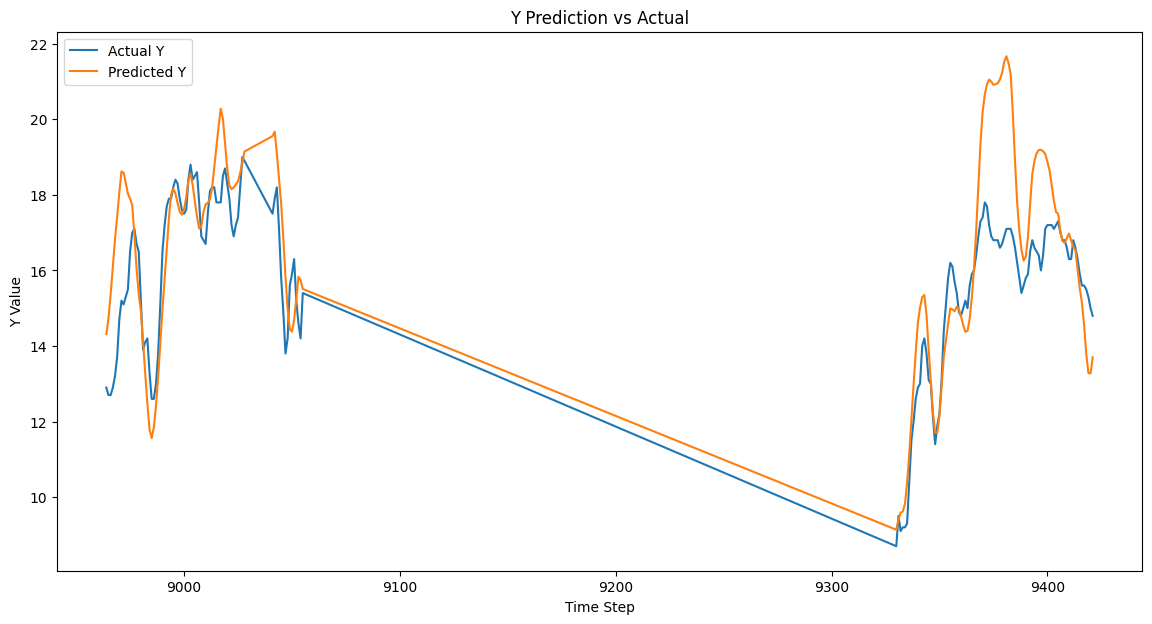

In [45]:
plt.figure(figsize=(14, 7))
plt.plot( summer_df['Y_test_original'], label='Actual Y')
plt.plot( summer_df['Y_pred'], label='Predicted Y')
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

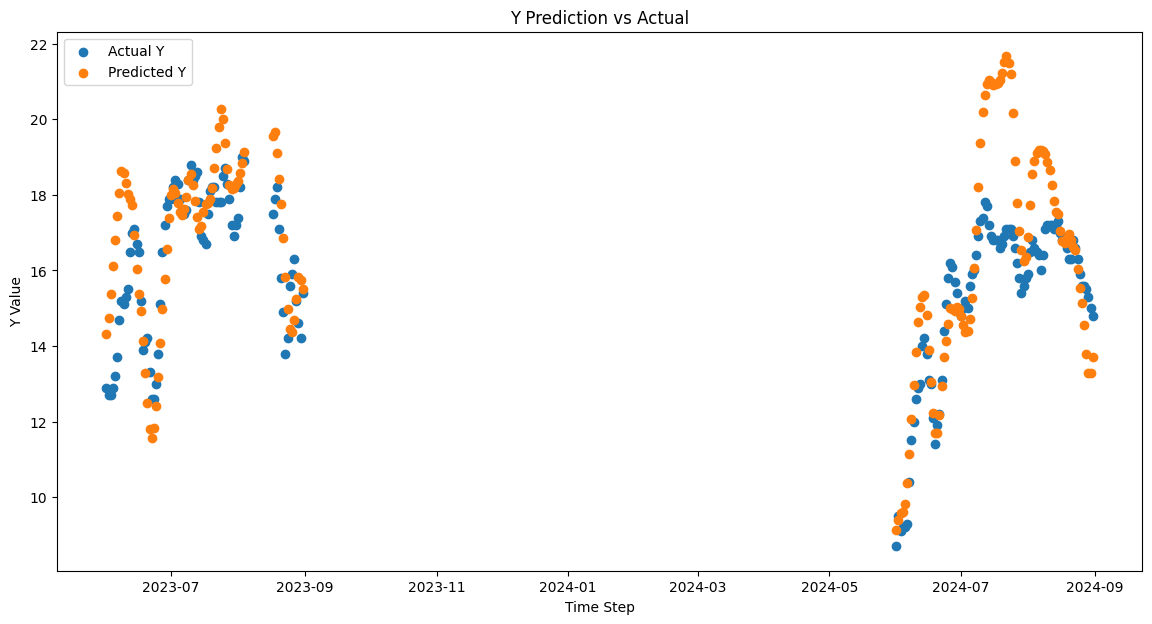

In [46]:
plt.figure(figsize=(14, 7))
plt.scatter(summer_df['Date'], summer_df['Y_test_original'], label='Actual Y')
plt.scatter(summer_df['Date'], summer_df['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

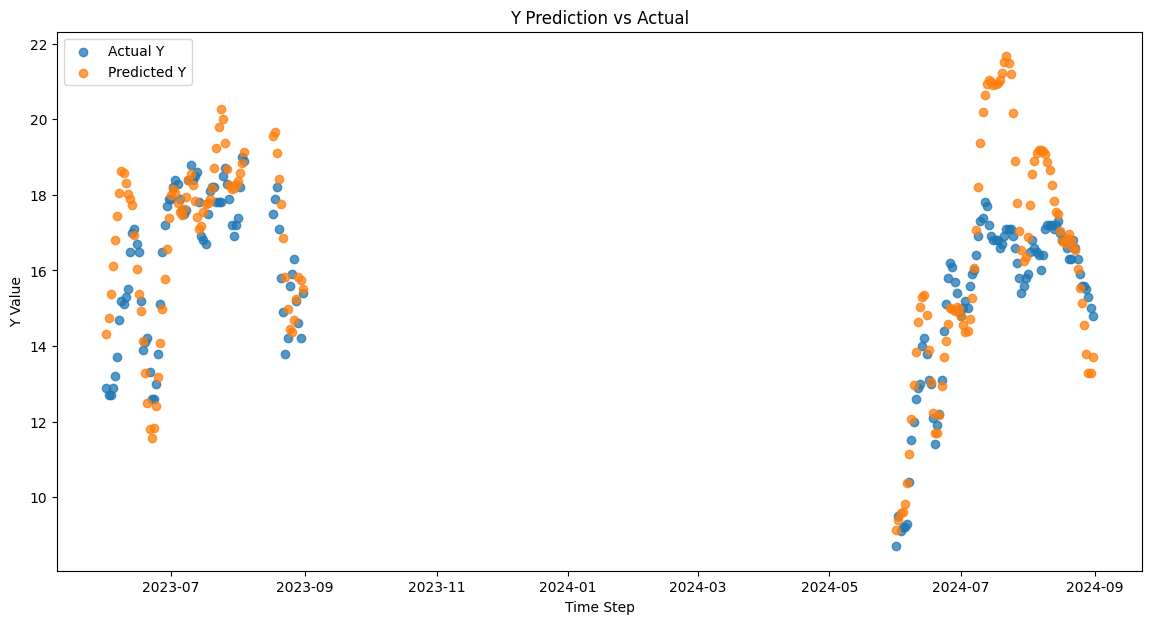

In [47]:
small= summer_df[0:256]
alpha=0.75
plt.figure(figsize=(14, 7))
plt.scatter( small['Date'],  small['Y_test_original'], label='Actual Y',alpha=alpha)
plt.scatter( small['Date'],  small['Y_pred'], label='Predicted Y',alpha=alpha)



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

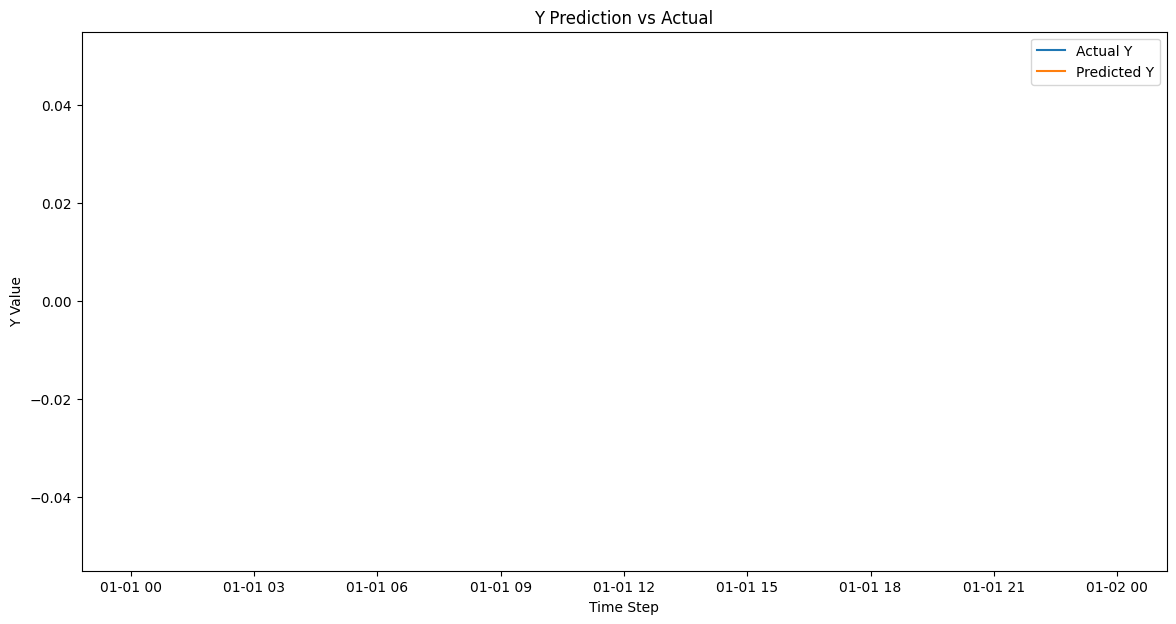

In [48]:
small= summer_df[187:256]

plt.figure(figsize=(14, 7))
plt.plot( small['Date'],  small['Y_test_original'], label='Actual Y')
plt.plot( small['Date'],  small['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

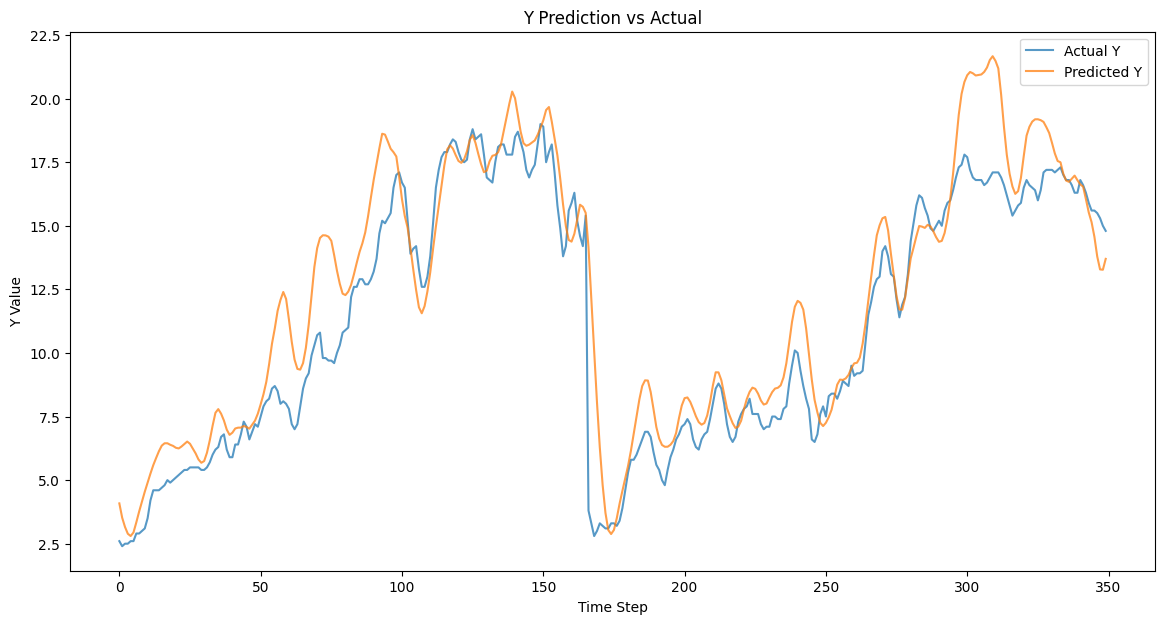

In [49]:



# --- 9. Visualize Predictions vs. Actual ---
plt.figure(figsize=(14, 7))
plt.plot(Y_test_original, label='Actual Y' ,alpha=alpha )
plt.plot(Y_pred, label='Predicted Y' ,alpha=alpha)
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()


In [50]:
result_df = pd.DataFrame({
    "current_time":[current_time],
                          "model_site": [model_site[0]],
                          "train_month" : [train_month]
                          , "h1":[h1]
                          ,"h2":[h2]
                          ,"d1":[d1]
                          ,"d2":[d2]
                          ,"batch":[batch]
                          ,"look_back":[look_back]


                          ,"optimizer":[optimizer]
    ,'learning_rate':[learning_rate]
    ,"r2" :[r2]
    , "rmse":[rmse]
                           , "bias":[bias]

                       ,   "std_ratio" :[std_ratio]
                        ,  "correlation" :[correlation]


    ,"KGE" : [kge_value]
,"KGE_r_comp" : [r_comp]
,"KGE_alpha_comp" : [alpha_comp]
,"KGE_beta_comp" : [beta_comp]
    })

print(result_df)


result_df.to_csv( model_site[0]+'_result_df.csv' , index=False)

result_df.to_csv('/content/drive/My Drive/LSTM_results/' + model_site[0]+'_result_df_'+   current_time.strftime("%Y%m%d%H%M") + '.csv' , index=False)


                current_time model_site         train_month   h1   h2   d1  \
0 2025-06-20 00:44:06.739147   12322000  [3, 4, 5, 6, 7, 8]  256  100  0.1   

    d2  batch  look_back                                          optimizer  \
0  0.1     16         21  <keras.src.optimizers.adam.Adam object at 0x7e...   

   learning_rate        r2      rmse      bias  std_ratio  correlation  \
0         0.0001  0.854682  1.752116  1.083736   1.006321     0.951365   

                    KGE            KGE_r_comp       KGE_alpha_comp  \
0  [0.8914700441654388]  [0.9513650188881047]  [1.006320687928521]   

          KGE_beta_comp  
0  [1.0968165214713255]  


In [51]:
#model.save( (model_site[0]+'_lstm_model.h5') )

         tmean   site_no       Date  00010_Mean  00060_Mean    Gap     Y_pred  \
8964  0.696240  12322000 2023-06-01    0.638191    0.414425 1 days  14.314227   
8965  0.731819  12322000 2023-06-02    0.628141    0.339815 1 days  14.739949   
8966  0.787928  12322000 2023-06-03    0.628141    0.305901 1 days  15.373368   
8967  0.788027  12322000 2023-06-04    0.638191    0.260683 1 days  16.109344   
8968  0.769878  12322000 2023-06-05    0.653266    0.217726 1 days  16.809305   

      Y_test_original      bias  
8964             12.9  1.414227  
8965             12.7  2.039949  
8966             12.7  2.673368  
8967             12.9  3.209344  
8968             13.2  3.609305  


/tmp/ipython-input-52-2963098943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']


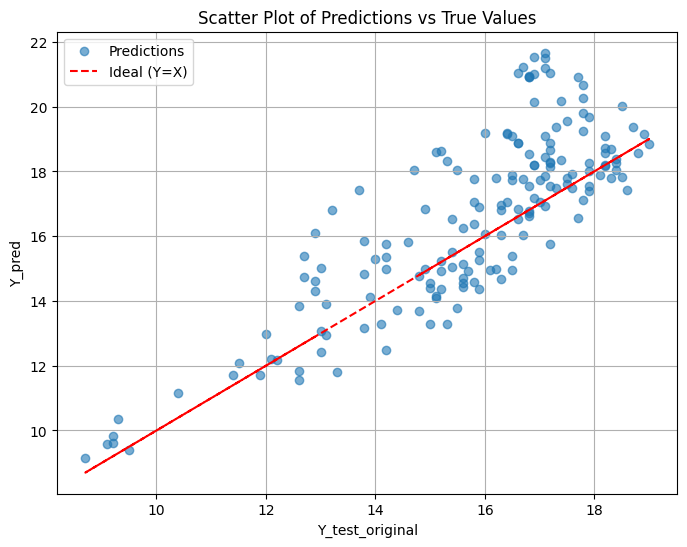

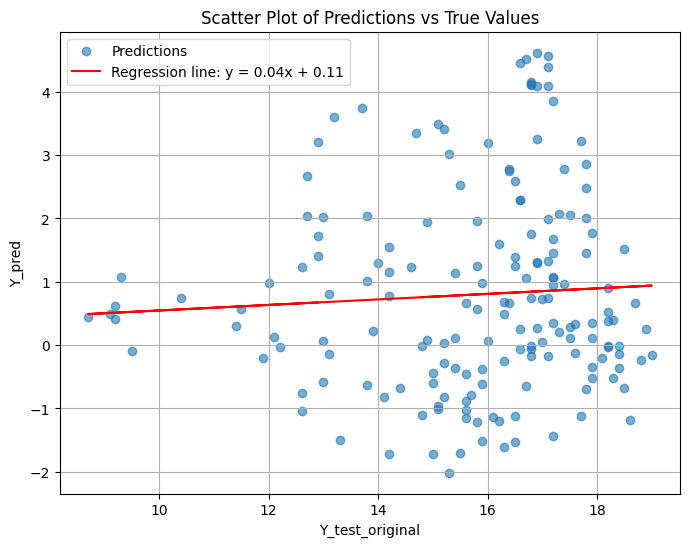

In [52]:
summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']
print( summer_df.head() )

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['Y_pred'], alpha=0.6, label='Predictions')
plt.plot( summer_df['Y_test_original'],  summer_df['Y_test_original'], color='red', linestyle='--', label='Ideal (Y=X)')
plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['bias'], alpha=0.6, label='Predictions')

# Calculate regression line
coefficients = np.polyfit(  summer_df['Y_test_original'],  summer_df['bias'] , 1)  # 1 for linear regression
polynomial = np.poly1d(coefficients)
y_pred = polynomial(  summer_df['Y_test_original']  )
# Plot regression line
plt.plot(  summer_df['Y_test_original'] , y_pred, color='red', label=f'Regression line: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')


plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

         tmean   site_no       Date  00010_Mean  00060_Mean    Gap     Y_pred  \
8964  0.696240  12322000 2023-06-01    0.638191    0.414425 1 days  14.314227   
8965  0.731819  12322000 2023-06-02    0.628141    0.339815 1 days  14.739949   
8966  0.787928  12322000 2023-06-03    0.628141    0.305901 1 days  15.373368   
8967  0.788027  12322000 2023-06-04    0.638191    0.260683 1 days  16.109344   
8968  0.769878  12322000 2023-06-05    0.653266    0.217726 1 days  16.809305   
...        ...       ...        ...         ...         ...    ...        ...   
9417  0.596877  12322000 2024-08-27    0.773869    0.082523 1 days  14.568389   
9418  0.549459  12322000 2024-08-28    0.768844    0.080262 1 days  13.792975   
9419  0.646441  12322000 2024-08-29    0.758794    0.088628 1 days  13.284989   
9420  0.734653  12322000 2024-08-30    0.743719    0.087497 1 days  13.273038   
9421  0.769117  12322000 2024-08-31    0.733668    0.075740 1 days  13.700425   

      Y_test_original      

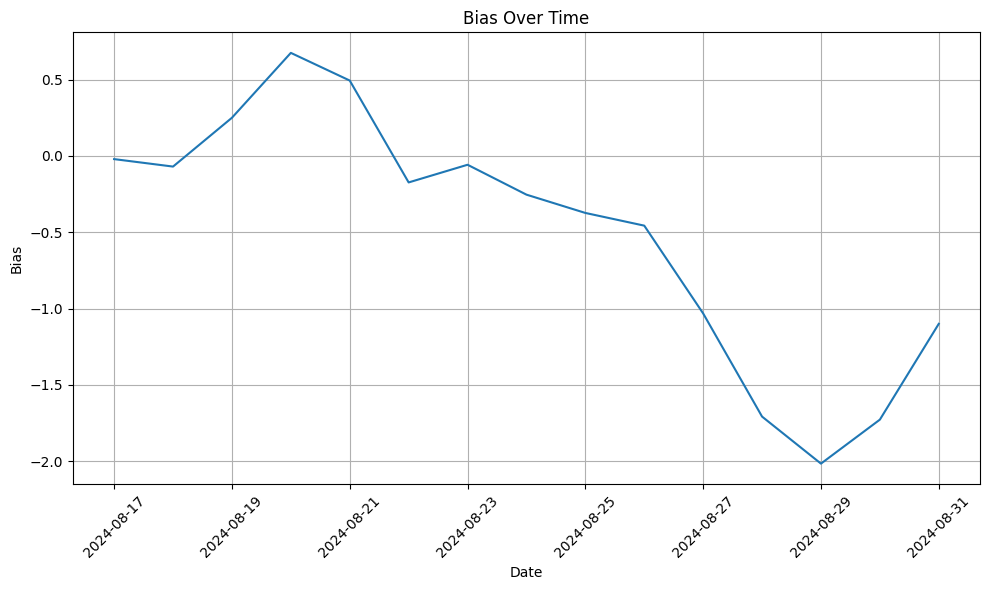

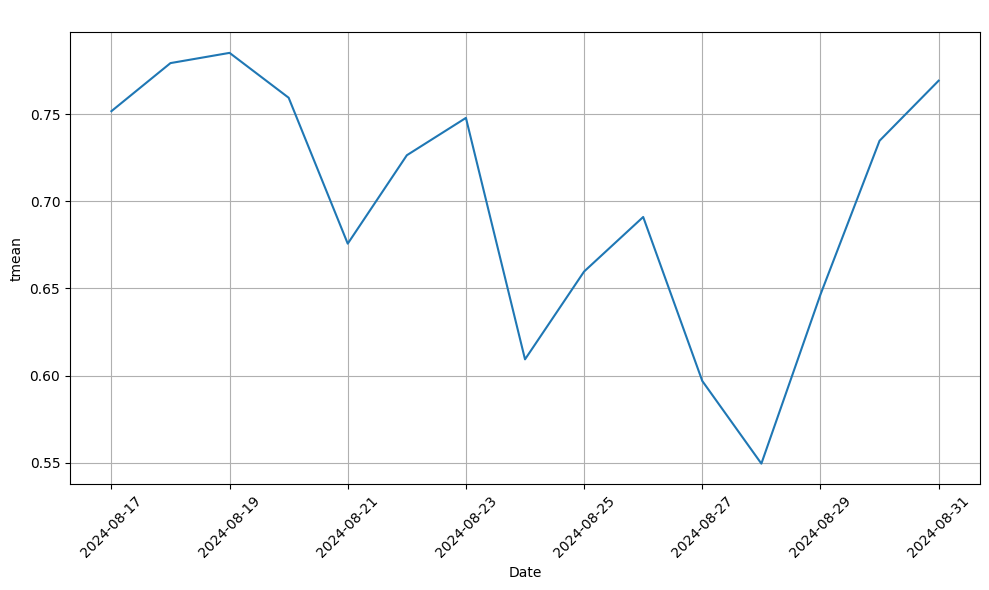

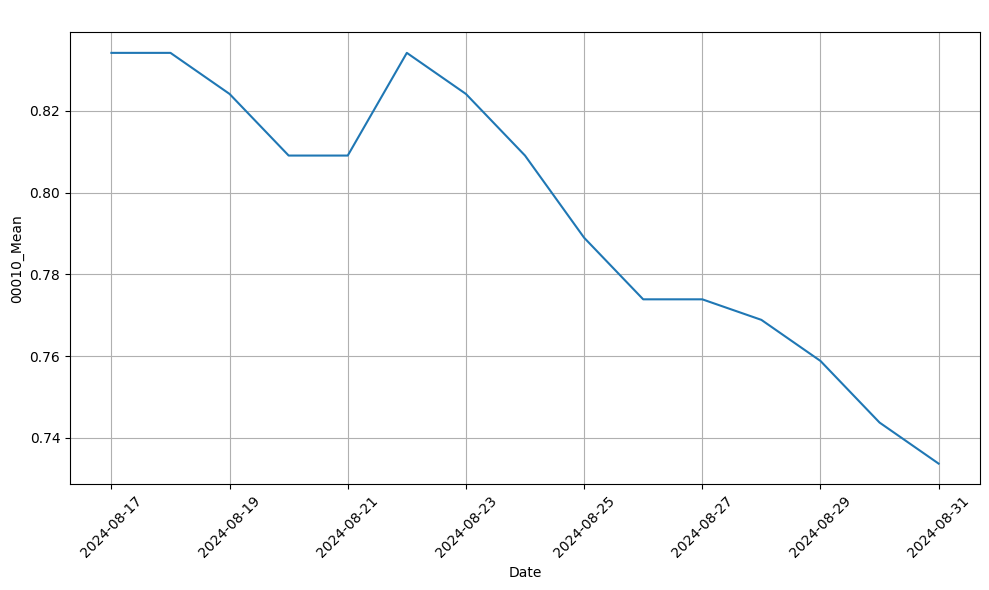

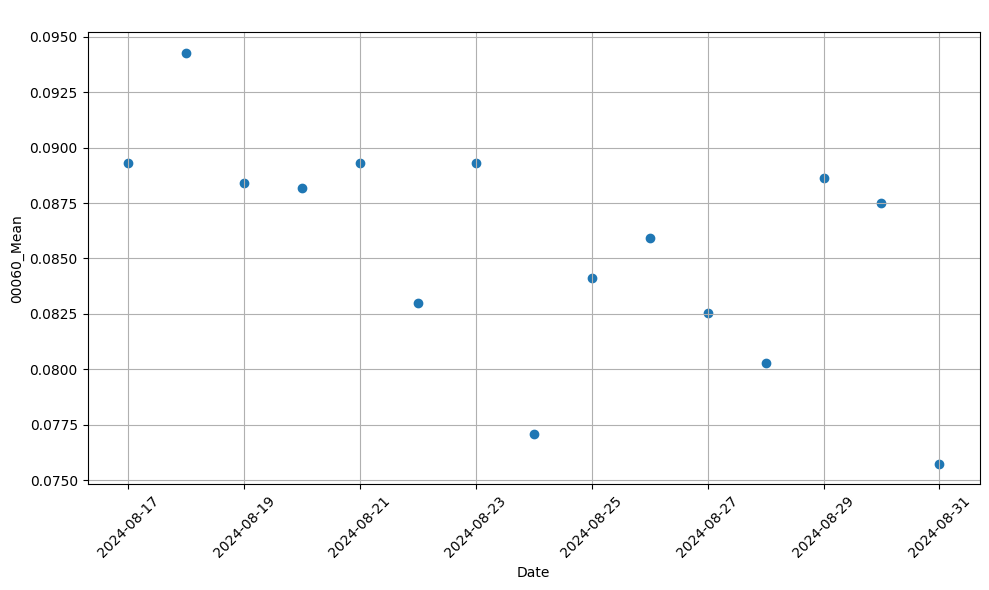

In [53]:
print(summer_df)

# --- prep ---
#summer_df['Date'] = summer_df.to_datetime( subset_rows['Date'])      # make sure Date is datetime
summer_df = summer_df.sort_values('Date').reset_index(drop=True)

# --- locate the peak bias ---
idx_peak   = summer_df['bias'].idxmin()             # row index of the max bias
date_peak  = summer_df.at[idx_peak, 'Date']         # corresponding date

# ------- OPTION 1: ±12 *days* around that date -------
start_day  = date_peak - pd.Timedelta(days=12)
end_day    = date_peak + pd.Timedelta(days=12)

subset_days = summer_df[(summer_df['Date'] >= start_day) & ( summer_df['Date'] <= end_day)].copy()

# ------- OPTION 2: ±12 *rows* around that row index -------
start_idx  = max(idx_peak - 12, 0)
end_idx    = min(idx_peak + 12, len(df) - 1)

subset_rows = summer_df.loc[start_idx : end_idx].copy()
subset_rows


# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(subset_rows['Date'], subset_rows['bias'])

# Customizing the plot
plt.title('Bias Over Time')
plt.xlabel('Date')
plt.ylabel('Bias')
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()





####

# Plotting
yvar = 'tmean'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(subset_rows['Date'], subset_rows[ yvar])

# Customizing the plot
plt.title(' ')
plt.xlabel('Date')
plt.ylabel( yvar )
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

####

# Plotting
yvar = '00010_Mean'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(subset_rows['Date'], subset_rows[ yvar])

# Customizing the plot
plt.title(' ')
plt.xlabel('Date')
plt.ylabel( yvar )
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

####

# Plotting
yvar = '00060_Mean'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(subset_rows['Date'], subset_rows[ yvar])

# Customizing the plot
plt.title(' ')
plt.xlabel('Date')
plt.ylabel( yvar )
plt.grid(True)

# Rotate x-axis labels if dates are crowded
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

https://www.sciencedirect.com/science/article/pii/S2214581824000648#sec0030